In [57]:
import os
from osgeo import gdal
from osgeo import ogr
from osgeo import osr
from osgeo import gdal_array
from osgeo import gdalconst
import matplotlib.pyplot as plt
import numpy as np
#%matplotlib notebook
import cv2
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

Segmentation Models: using `keras` framework.


In [4]:
os.system("gdalinfo")

1

In [5]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# TIF 2

In [66]:
dataset1=gdal.Open('Clip_20180903.tif',gdal.GA_ReadOnly)

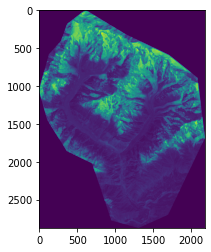

In [70]:
band = dataset1.GetRasterBand(1)
arr = band.ReadAsArray()
plt.imshow(arr)

In [68]:
bandList2=[]
for i in range (1,12):
    band = dataset1.GetRasterBand(i)
    arr = band.ReadAsArray()
    row=arr.shape[0]-(int(arr.shape[0]/256)*256)
    col=arr.shape[1]-(int(arr.shape[1]/256)*256)
    l=list(range(arr.shape[0]-row,arr.shape[0]))
    x=np.delete(arr,l,0)
    l=list(range(arr.shape[1]-col,arr.shape[1]))
    x=np.delete(x,l,1)
    arr=x
    bandList2.append(arr)

In [10]:
np.unique(bandList2[0]).shape

(12844,)

In [11]:
arr.shape

(2816, 2048)

In [17]:
multiDimArray=np.zeros((arr.shape[0],arr.shape[1],16))
for i in range (1,12):
    band = dataset1.GetRasterBand(i)
    arr = band.ReadAsArray()
    row=arr.shape[0]-(int(arr.shape[0]/256)*256)
    col=arr.shape[1]-(int(arr.shape[1]/256)*256)
    l=list(range(arr.shape[0]-row,arr.shape[0]))
    x=np.delete(arr,l,0)
    l=list(range(arr.shape[1]-col,arr.shape[1]))
    x=np.delete(x,l,1)
    x = ((x - x.min()) * (1/(x.max() - x.min()) * 255)).astype('uint8')
    arr=x
    multiDimArray[:,:,i-1]=arr

## Ground Truth images 

In [18]:
oneBandArray=multiDimArray[:,:,0]

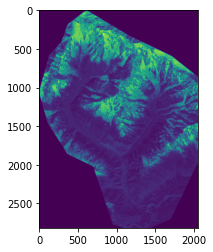

In [19]:
plt.imshow(oneBandArray)

In [20]:
np.unique(oneBandArray)

array([  0.,   9.,  10.,  11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,
        19.,  20.,  21.,  22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,
        30.,  31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,
        41.,  42.,  43.,  44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,
        52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,
        63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,
        74.,  75.,  76.,  77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,
        85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,
        96.,  97.,  98.,  99., 100., 101., 102., 103., 104., 105., 106.,
       107., 108., 109., 110., 111., 112., 113., 114., 115., 116., 117.,
       118., 119., 120., 121., 122., 123., 124., 125., 126., 127., 128.,
       129., 130., 131., 132., 133., 134., 135., 136., 137., 138., 139.,
       140., 141., 142., 143., 144., 145., 146., 147., 148., 149., 150.,
       151., 152., 153., 154., 155., 156., 157., 15

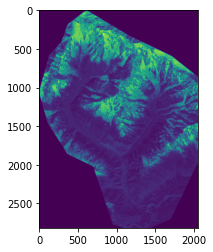

In [21]:
oneBandArray *= 255.0/oneBandArray.max() 
plt.imshow(oneBandArray)

In [22]:
iceRange=60
debriRange=0

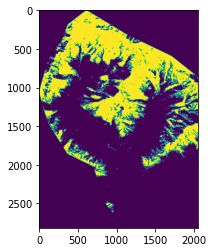

In [23]:
labelImg0=(oneBandArray>55).astype(int)
labelImg1=(oneBandArray>0)
labelImg11=(oneBandArray<=55)
labelImg1=(labelImg1*labelImg11).astype(int)
labelImg2=(oneBandArray==0).astype(int)
#labelImg=np.where(oneBandArray>55,2,oneBandArray)
#labelImg=np.where((oneBandArray>0) & (oneBandArray<=55) ,1,labelImg)
#labelImg=np.where(oneBandArray>0,1,oneBandArray)
#np.unique(labelImg)
plt.imshow(labelImg0)

In [24]:

labelImg1.shape

(2816, 2048)

In [25]:
#window_name = "image"
#cv2.imshow(window_name, labelImg1)
#cv2.setWindowProperty(window_name, cv2.WND_PROP_TOPMOST, 1)
#cv2.waitKey(0)

In [26]:
np.unique(labelImg1)


array([0, 1])

In [27]:
multiDimArray[:,:,13]=labelImg0
multiDimArray[:,:,14]=labelImg1
multiDimArray[:,:,15]=labelImg2

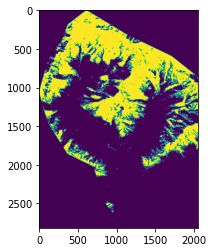

In [28]:
plt.imshow(multiDimArray[:,:,13])

## Patches

In [29]:
from sklearn.feature_extraction import image
import cv2

In [30]:
multiDimArray.shape

(2816, 2048, 16)

In [31]:
X=multiDimArray

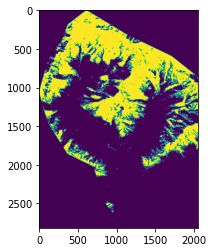

In [32]:
plt.imshow(X[:,:,13])

In [34]:
patches=image.extract_patches_2d(X,(256,256), max_patches=300)

In [35]:
patches.shape

(300, 256, 256, 16)

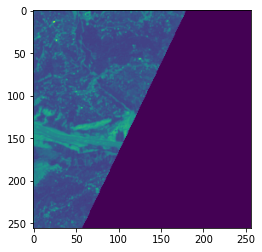

In [36]:
plt.imshow(patches[0][:,:,0])

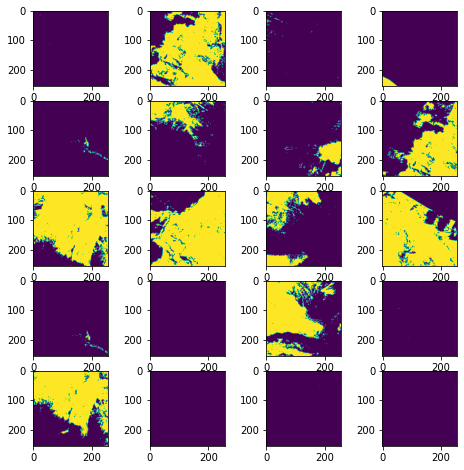

In [37]:
w = 10
h = 10
fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = patches[i-1][:,:,13]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

## Train and test data

In [38]:
from sklearn.model_selection import train_test_split


In [39]:
X=patches
print(X.shape)
y=patches[:,:,:,13]
print(y.shape)

(300, 256, 256, 16)
(300, 256, 256)


In [40]:
xTrain,xTest,yTrain,yTest=train_test_split(X,y, test_size=0.33, random_state=42)

## Model

In [41]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

In [62]:
def unet(input_size = (256,256,16)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'softmax')(conv9)
    model = Model(inputs, conv10)

    model.compile(optimizer ='adam', loss = bce_jaccard_loss, metrics = [iou_score])
    return model

In [63]:
model=unet(input_size = (256,256,16))
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                6)]                                                               
                                                                                                  
 conv2d_120 (Conv2D)            (None, 256, 256, 64  9280        ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_121 (Conv2D)            (None, 256, 256, 64  36928       ['conv2d_120[0][0]']             
                                )                                                           

In [64]:
EPOCHS=5
BATCHSIZE=2
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"]="/device:GPU:0" 

In [65]:
hist=model.fit(x=xTrain,y=yTrain,validation_data=(xTest,yTest),epochs=EPOCHS,batch_size=BATCHSIZE,verbose=1)

Epoch 1/5
101/101 [==============================] - 405s 4s/step - loss: 12.3578 - iou_score: 0.2398 - val_loss: 11.1835 - val_iou_score: 0.3086
Epoch 2/5
101/101 [==============================] - 405s 4s/step - loss: 12.3578 - iou_score: 0.2388 - val_loss: 11.1835 - val_iou_score: 0.3086
Epoch 3/5
101/101 [==============================] - 402s 4s/step - loss: 12.3578 - iou_score: 0.2386 - val_loss: 11.1835 - val_iou_score: 0.3086
Epoch 4/5
101/101 [==============================] - 404s 4s/step - loss: 12.3578 - iou_score: 0.2416 - val_loss: 11.1835 - val_iou_score: 0.3086
Epoch 5/5
101/101 [==============================] - 400s 4s/step - loss: 12.3578 - iou_score: 0.2383 - val_loss: 11.1835 - val_iou_score: 0.3086


In [102]:
def plotHist():
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title("accuracy deep model for LandDebriIce")
    plt.xlabel('ephocs')
    plt.ylabel('accuracy')
    plt.legend(['train','validation'])
    plt.show()

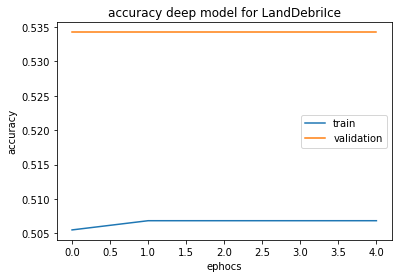

In [103]:
plotHist()

In [104]:
yPred=model.predict(xTest)

In [110]:
def blockshaped(arr, nrows, ncols):
    """
    Return an array of shape (n, nrows, ncols) where
    n * nrows * ncols = arr.size

    If arr is a 2D array, the returned array should look like n subblocks with
    each subblock preserving the "physical" layout of arr.
    """
    h, w = arr.shape
    assert h % nrows == 0, f"{h} rows is not evenly divisible by {nrows}"
    assert w % ncols == 0, f"{w} cols is not evenly divisible by {ncols}"
    return (arr.reshape(h//nrows, nrows, -1, ncols)
               .swapaxes(1,2)
               .reshape(-1, nrows, ncols))

In [111]:
multiDimArray.shape

(2816, 2560, 14)

In [112]:
x=blockshaped(multiDimArray[:,:,0], nrows=256, ncols=256)
x.shape

(110, 256, 256)

In [113]:
patchX=np.zeros((x.shape[0],x.shape[1],x.shape[2],14))
for i in range (multiDimArray.shape[2]):
    patchX[:,:,:,i]=blockshaped(multiDimArray[:,:,i], nrows=256, ncols=256)

In [114]:
patchX.shape

(110, 256, 256, 14)

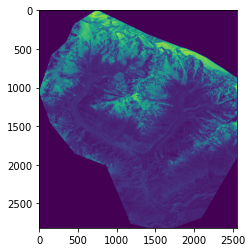

In [115]:
plt.imshow(multiDimArray[:,:,0])

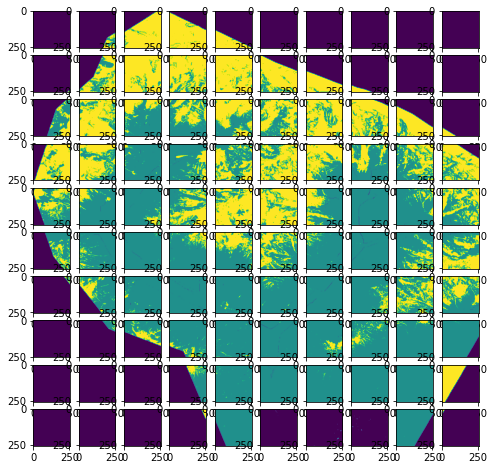

In [116]:
w = 10
h = 10
fig = plt.figure(figsize=(8, 8))
columns = 10
rows = 10
for i in range(1, columns*rows +1):
    img = patchX[i-1][:,:,13]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

In [117]:
yPred=model.predict(patchX)

In [125]:
yPred[0]

array([[[0.5035343],
        [0.5035343],
        [0.5035343],
        ...,
        [0.5035343],
        [0.5035343],
        [0.5035343]],

       [[0.5035343],
        [0.5035343],
        [0.5035343],
        ...,
        [0.5035343],
        [0.5035343],
        [0.5035343]],

       [[0.5035343],
        [0.5035343],
        [0.5035343],
        ...,
        [0.5035343],
        [0.5035343],
        [0.5035343]],

       ...,

       [[0.5035343],
        [0.5035343],
        [0.5035343],
        ...,
        [0.5035343],
        [0.5035343],
        [0.5035343]],

       [[0.5035343],
        [0.5035343],
        [0.5035343],
        ...,
        [0.5035343],
        [0.5035343],
        [0.5035343]],

       [[0.5035343],
        [0.5035343],
        [0.5035343],
        ...,
        [0.5035343],
        [0.5035343],
        [0.5035343]]], dtype=float32)

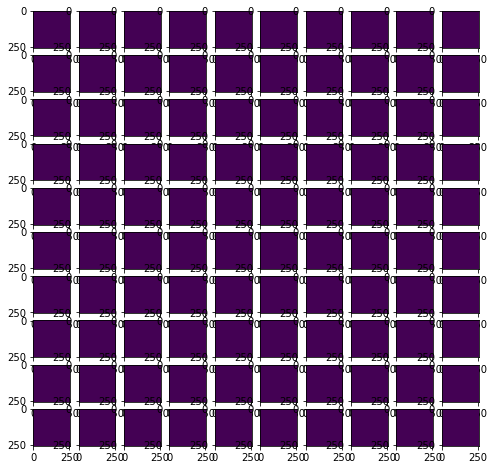

In [120]:
w = 10
h = 10
fig = plt.figure(figsize=(8, 8))
columns = 10
rows = 10
for i in range(1, columns*rows +1):
    img = yPred[i-1][:,:]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

In [50]:
tf.test.is_built_with_cuda()

True

In [51]:
tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [52]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [53]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

['/device:CPU:0', '/device:GPU:0']
